In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [ ]:
class Object():
    def __init__(self,State):
        self.State=State
        self.Valid=True
        self.St=np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]])
        self.Obs=np.array([[1,0,0,0],[0,1,0,0]])
        Poscov=4
        SpeedCov=4
        self.StCov=np.array([[Poscov,0,0,0],[0,Poscov,0,0],[0,0,SpeedCov,0],[0,0,0,SpeedCov]])
        ObsCovPos=4
        #ObsCovSpeed=4
        self.ObsCov=np.array([[ObsCovPos,0],[0,ObsCovPos]])
        self.ProbDet=0.98 #probabilty of detection

    def Step(self):
        self.State=np.matmul(self.St,self.State)+np.random.multivariate_normal(np.zeros(4),self.StCov)

    def Measure(self):
        seen=True
        Obs=np.matmul(self.Obs,self.State)+np.random.multivariate_normal(np.zeros(2),self.ObsCov)
        if np.random.uniform()>self.ProbDet:
            seen=False
        return Obs, seen

    def Stop(self):
        self.Valid=False


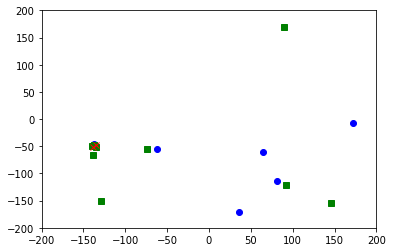

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


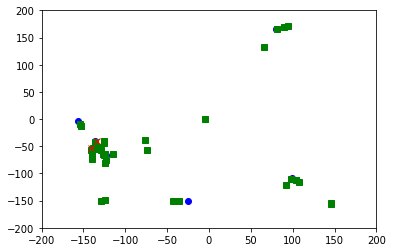

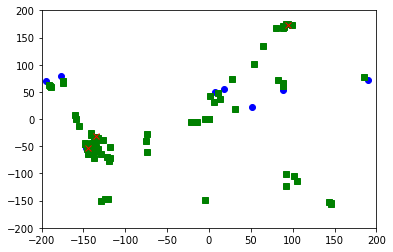

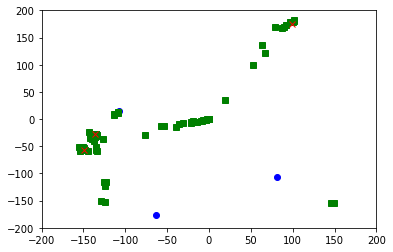

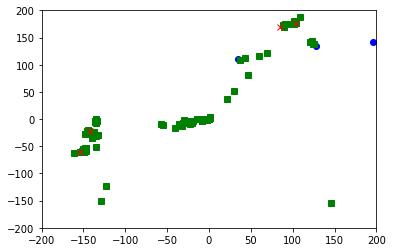

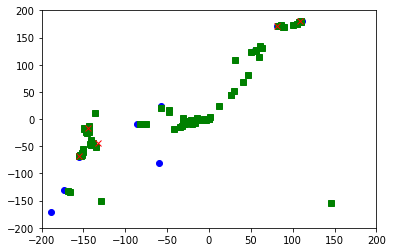

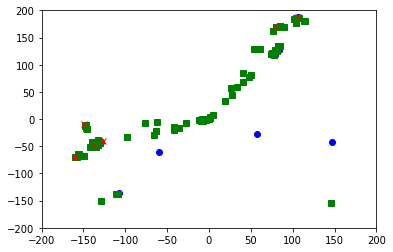

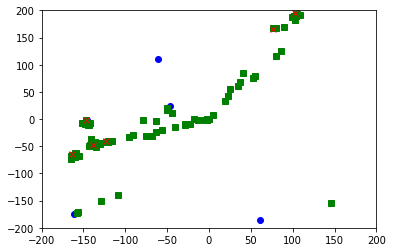

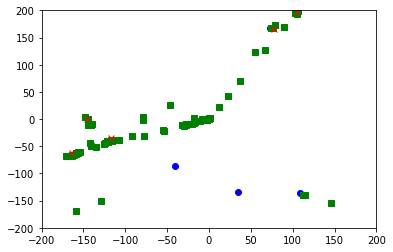

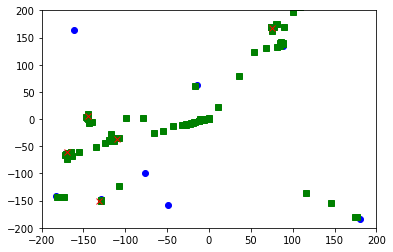

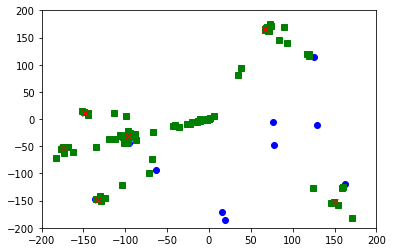

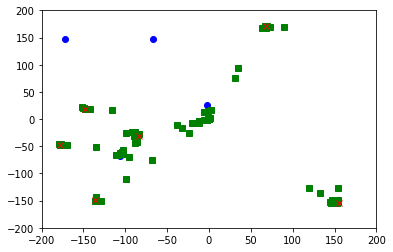

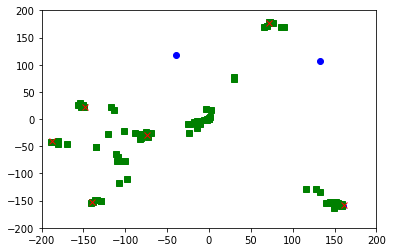

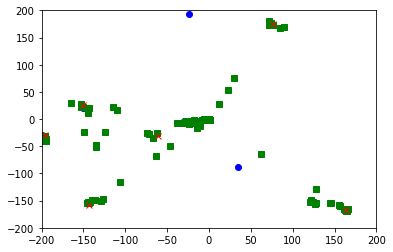

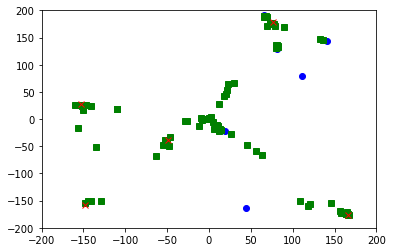

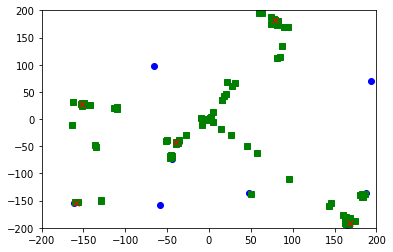

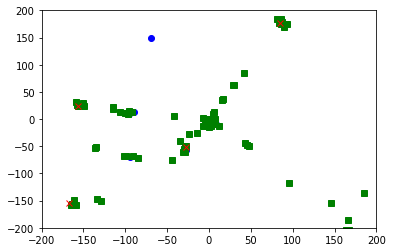

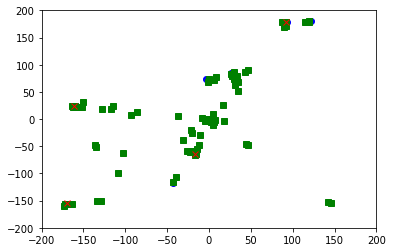

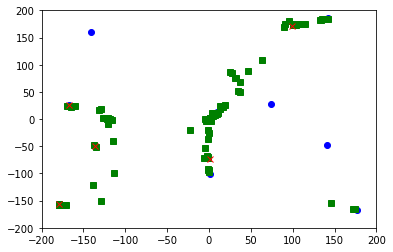

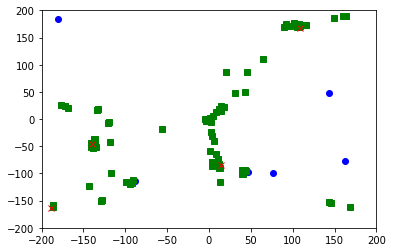

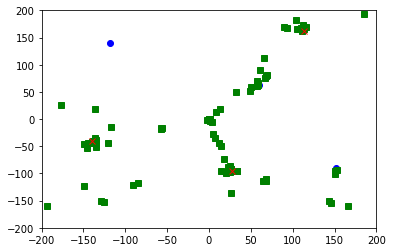

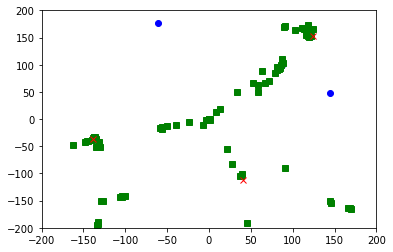

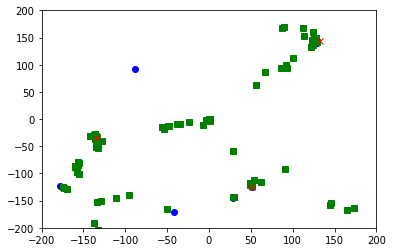

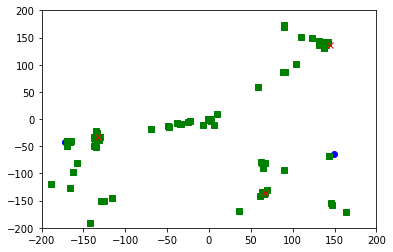

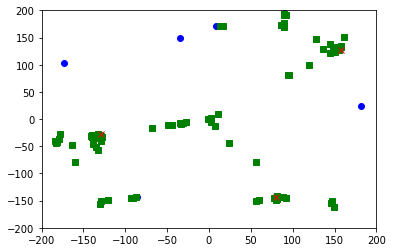

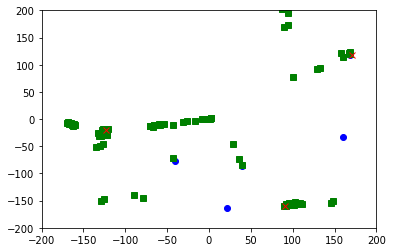

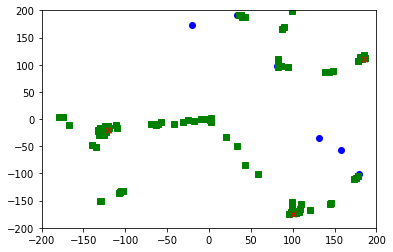

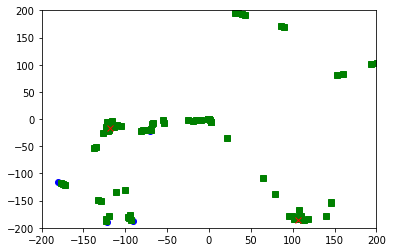

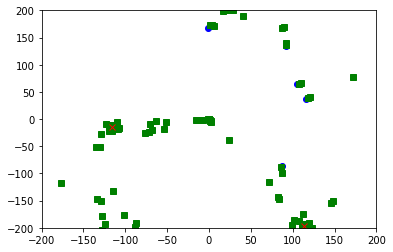

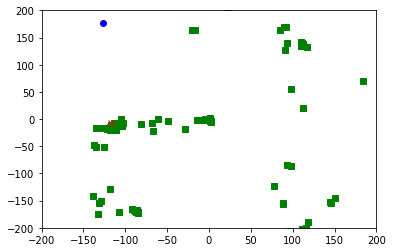

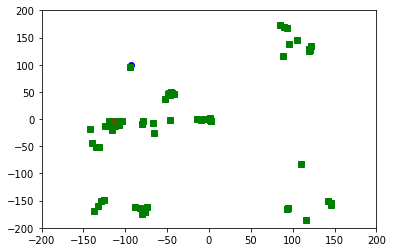

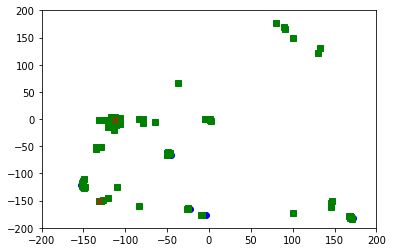

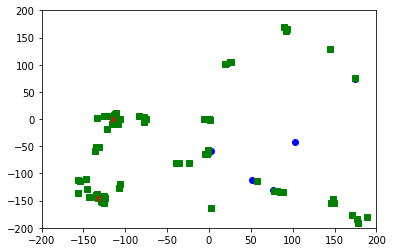

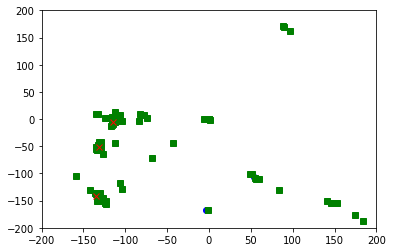

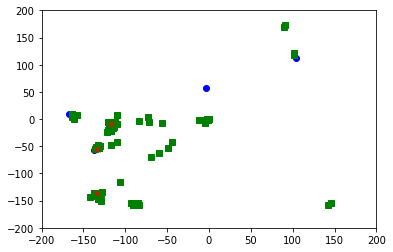

KeyboardInterrupt: ignored

In [ ]:
class PhDFilter():
    def __init__(self,AppearencePositions):
        self.StateDim=4
        self.ObsDim=2
        self.StateSpace=[[-200,200],[-200,200]]
        self.NumGaussians=0
        self.weights=[]
        self.means=[]
        self.covs=[]

        self.AppearencePositions=AppearencePositions

        self.St=np.array([[1,0,1,0],[0,1,0,1],[0,0,1,0],[0,0,0,1]])
        Poscov=40
        SpeedCov=40
        self.StCov=np.array([[Poscov,0,0,0],[0,Poscov,0,0],[0,0,SpeedCov,0],[0,0,0,SpeedCov]])

        #Algo params
        self.Obs=np.array([[1,0,0,0],[0,1,0,0]])

        ObsCovPos=40
        self.ObsCov=np.array([[ObsCovPos,0],[0,ObsCovPos]])

        self.Survival=1.0-0.01
        self.Detection=0.98
        self.FalsePosRate=1.25e-4

    def UpdateNonDetected(self):
         NewWeights=np.zeros(self.NumGaussians)
         NewMeans=np.zeros((self.NumGaussians,self.StateDim))
         NewCovs=np.zeros((self.NumGaussians,self.StateDim,self.StateDim))
         NewWeights=(1-self.Detection)*self.weights
         NewMeans=self.means
         NewCovs=self.covs
         return NewWeights,NewMeans,NewCovs

    def CalcKalman(self):
         Zkhs=np.zeros((self.NumGaussians,self.ObsDim)) #mean mapped to observation spaces
         Skhs=np.zeros((self.NumGaussians,self.ObsDim,self.ObsDim)) #total variance
         Kkhs=np.zeros((self.NumGaussians,self.StateDim,self.ObsDim)) #Kalman Gains
         Pkhs=np.zeros((self.NumGaussians,self.StateDim,self.StateDim)) #Kalupdated covariances
         for h in range(self.NumGaussians):
            Zkhs[h,:] = np.matmul(self.Obs, self.means[h,:])   #mean in state of observation
            Skhs[h,:,:] = self.ObsCov+np.matmul(np.matmul(self.Obs,self.covs[h,:,:]),self.Obs.T)

            #check if SKHS is invertible
            if np.linalg.det(Skhs[h,:,:])!=0.0:
                Kkhs[h,:,:]= np.matmul( self.covs[h,:] , np.matmul(self.Obs.T,np.linalg.inv(Skhs[h,:,:])) )
            else:
                Kkhs[h,:,:]=[[0.5, 0. ], [0.,  0.5], [0.,  0. ], [0.,  0. ]]
            Pkhs[h,:,:]= np.matmul( (np.identity(4)- np.matmul(Kkhs[h,:,:],self.Obs)) , self.covs[h,:,:])

         return  Zkhs, Skhs, Kkhs, Pkhs


    def UpdateMeas(self,Measurements, OldWeights, OldMeans, OldCovs,Zkhs,Skhs,Kkhs,Pkhs ):
         NewWeights=np.zeros(len(Measurements)*self.NumGaussians)
         NewMeans=np.zeros((len(Measurements)*self.NumGaussians,self.StateDim))
         NewCovs=np.zeros((len(Measurements)*self.NumGaussians,self.StateDim,self.StateDim))
         for m in range(len(Measurements)):
            WTilde=np.zeros(self.NumGaussians)
            for h in range(self.NumGaussians):

                NewMeans[m*self.NumGaussians+h,:]=OldMeans[h,:]+np.matmul(Kkhs[h,:,:], (Measurements[m]-Zkhs[h,:]))
                NewCovs[m*self.NumGaussians+h,:,:]=Pkhs[h,:,:]
                GProb=self.GaussProbDens(Measurements[m],Zkhs[h,:], Skhs[h,:,:],self.ObsDim)
                WTilde[h]=self.Detection*self.weights[h] *GProb
            WSum=np.sum(WTilde)

            NewWeights[m*self.NumGaussians:(m+1)*self.NumGaussians]=WTilde/(self.FalsePosRate+WSum)
         return NewWeights,NewMeans,NewCovs


    def Iterate(self,Measurements):
         for h in range(self.NumGaussians):

                self.weights[h]=self.weights[h]*self.Survival
                self.means[h,:]=np.matmul(self.St,self.means[h,:])
                self.covs[h,:,:]=np.matmul(np.matmul(self.St,self.covs[h,:,:]),self.St.T)+self.StCov

         #birthprocess
         NumBirthPlaces=self.AppearencePositions.shape[0]


         BirthWeights=np.ones(NumBirthPlaces)
         BirthMeans=np.zeros((NumBirthPlaces,self.StateDim))
         InitPoscov=200
         InitSpeedCov=100

         BirthConvs=np.tile( np.array([[InitPoscov,0,0,0],[0,InitPoscov,0,0],[0,0,InitSpeedCov,0],[0,0,0,InitSpeedCov]]), (NumBirthPlaces,1,1))
         for i in range(NumBirthPlaces):
             BirthMeans[i,:2]=self.AppearencePositions[i,:]
             BirthMeans[i,2:]= np.random.uniform(-5,5,2) #birth with random speed

         self.NumGaussians+=NumBirthPlaces
         if self.means==[]:
            self.weights=BirthWeights
            self.means=BirthMeans
            self.covs=BirthConvs
         else:
            self.weights=np.concatenate( (self.weights,BirthWeights),0)
            self.means=np.concatenate( (self.means,BirthMeans),0)
            self.covs=np.concatenate( (self.covs,BirthConvs),0)


         NewWeights=np.zeros( (len(Measurements)+1)*self.NumGaussians)
         NewMeans=np.zeros(( (len(Measurements)+1)*self.NumGaussians,self.StateDim))
         NewCovs=np.zeros(( (len(Measurements)+1)*self.NumGaussians,self.StateDim,self.StateDim))


         Zkhs,Skhs,Kkhs,Pkhs =self.CalcKalman()

         NewWeights[:self.NumGaussians], NewMeans[:self.NumGaussians,:],NewCovs[:self.NumGaussians,:,:]=self.UpdateNonDetected()
         NewWeights[self.NumGaussians:], NewMeans[self.NumGaussians:,:], NewCovs[self.NumGaussians:,:,:]=self.UpdateMeas(Measurements, NewWeights[:self.NumGaussians], NewMeans[:self.NumGaussians,:],NewCovs[:self.NumGaussians,:,:],Zkhs,Skhs,Kkhs,Pkhs)

         #rewrite the old ones
         self.weights=NewWeights
         self.means=NewMeans
         self.covs=NewCovs
         self.NumGaussians=(len(Measurements)+1)*self.NumGaussians

         #Truncation
         truncthresh=1e-10
         mergethresh=1.0
         maxcomponents=100

         AfterTruncW=[]
         AfterTruncM=[]
         AfterTruncC=[]
         for n in range(self.NumGaussians):
                if self.weights[n]>truncthresh:
                        AfterTruncW.append(self.weights[n])
                        AfterTruncM.append(self.means[n])
                        AfterTruncC.append(self.covs[n])

         NumGaussians=len(AfterTruncW)

         #sort the weights
         Values, Indices=zip(*sorted(zip(AfterTruncW, range(NumGaussians )),reverse=True))
         AfterTruncW=[AfterTruncW[i] for i in Indices]
         AfterTruncM=[AfterTruncM[i] for i in Indices]
         AfterTruncC=[AfterTruncC[i] for i in Indices]

         MergedW=[]
         MergedM=[]
         MergedC=[]
         while AfterTruncW!=[]:
                SelectedM=AfterTruncM[0]
                ToRemove=[]
                NumGaussians=len(AfterTruncW)
                for n in range(1,NumGaussians):
                    dist= (AfterTruncM[n][0]-SelectedM[0])*(AfterTruncM[n][0]-SelectedM[0])+(AfterTruncM[n][1]-SelectedM[1])*(AfterTruncM[n][1]-SelectedM[1])
                    if dist<mergethresh:
                        ToRemove.append(n)
                if ToRemove==[]:
                   MergedW.append(AfterTruncW[0])
                   MergedM.append(AfterTruncM[0])
                   MergedC.append(AfterTruncC[0])
                   AfterTruncW.pop(0)
                   AfterTruncM.pop(0)
                   AfterTruncC.pop(0)
                else:
                   SelectedW=np.array([AfterTruncW[i] for i in ToRemove])
                   SelectedM=np.array([AfterTruncM[i] for i in ToRemove])
                   SelectedC=np.array([AfterTruncC[i] for i in ToRemove])
                   SumW=AfterTruncW[0]+sum(SelectedW)
                   SumM=np.array(AfterTruncW[0])*np.array(AfterTruncM[0])

                   SumC=np.array(AfterTruncW[0])*np.array(AfterTruncC[0])
                   for n in ToRemove:
                      SumM+=AfterTruncW[n]*AfterTruncM[n]
                      Div=np.array(AfterTruncM[0])-AfterTruncM[n]
                      SumC+=np.array(AfterTruncW[n])* (np.array(AfterTruncC[n]) +np.matmul(Div,Div.T) )
                   MergedW.append(SumW)
                   MergedM.append(SumM)
                   MergedC.append(SumC)
                   for i in sorted(ToRemove,reverse=True):
                        AfterTruncW.pop(i)
                        AfterTruncM.pop(i)
                        AfterTruncC.pop(i)

         #If more remaining keep top
         NumGaussians=len(MergedW)
         Values, Indices=zip(*sorted(zip(MergedW, range(NumGaussians )),reverse=True))
         #Indices=np.array(Indices)

         self.weights=np.array([MergedW[i] for i in Indices[:maxcomponents]])
         self.means=np.array([MergedM[i] for i in Indices[:maxcomponents]])
         self.covs=np.array([MergedC[i] for i in Indices[:maxcomponents]]  )
         self.NumGaussians=self.weights.shape[0]

    def GaussProbDens(self,x,mean,cov,Dim):
        p1 =  np.power( 2.0*np.pi,-Dim /2.0)
        p2 =  np.power(np.linalg.det(cov), -0.5)
        if np.linalg.det(cov)!=0:
                inv = np.linalg.inv(cov)
        else:
                Poscov=0.1
                SpeedCov=0.01
                cov=np.array([[Poscov,0,0,0],[0,Poscov,0,0],[0,0,SpeedCov,0],[0,0,0,SpeedCov]])
                inv = np.linalg.inv(cov)
        p3 =  np.exp(-0.5 * np.matmul(np.matmul((x-mean), inv), (x-mean).T))
        pdf=p1*p2*p3
        return pdf

    def CalcPhD(self):
        XDist=self.StateSpace[0][1]-self.StateSpace[0][0]
        YDist=self.StateSpace[1][1]-self.StateSpace[1][0]
        prob=np.zeros((XDist,YDist))
        for h in range(self.NumGaussians):
                p1 =  np.power( 2.0*np.pi,-self.ObsDim /2.0)
                p2 =  np.power(np.linalg.det(self.covs[h,:2,:2]), -0.5)
                inv = np.linalg.inv(self.covs[h,:2,:2])
                S1=self.weights[h] * p1*p2
                for i in range(XDist):
                    XPos=i-self.StateSpace[0][1]
                    for j in range(XDist):
                        YPos=j-self.StateSpace[0][1]
                        x=np.array([XPos,YPos])
                        S2= np.exp( -0.5 * np.matmul( np.matmul( (x-self.means[h,:2]).T, inv), (x-self.means[h,:2]) ) )
                        prob[i][j]+=S1* S2
        #prob/=np.amax(prob)
        print(prob/np.amax(prob))
        print(np.amin(prob))
        print(np.amax(prob))
        return prob





#Create 2D Simulation
class Simulation():
    def __init__(self,NumAppearencePositions=4,ObjectAppearenceProb=0.1,ObjectStopProb=0.01):
        self.Dim=2
        self.StateSpace=[[-200,200],[-200,200]]  #Size of State Space
        self.NumAppearencePositions=NumAppearencePositions
        self.AppearencePositions=np.zeros((NumAppearencePositions,self.Dim))
        self.ObjectAppearenceProb=ObjectAppearenceProb
        self.ObjectStopProb=ObjectStopProb


        self.Objects=[]
        #self.RealTrajectories=[]
        #self.Observations=[]

        #Select Positions For appearence
        self.AppearencePositions[:,0]=np.random.uniform(self.StateSpace[0][0],self.StateSpace[0][1],NumAppearencePositions)
        self.AppearencePositions[:,1]=np.random.uniform(self.StateSpace[1][0],self.StateSpace[1][1],NumAppearencePositions)
        #Add two objects as default
        self.Objects.append(Object(np.concatenate( (self.AppearencePositions[0,:], np.random.uniform(-5,5,2)),0)))
        self.Objects.append(Object(np.concatenate( (self.AppearencePositions[1,:], np.random.uniform(-5,5,2)),0)))

        self.Filter=PhDFilter(self.AppearencePositions)

    def Step(self):
        #GenerateNewObjects - only one object can appear at one position
        for p in range(self.NumAppearencePositions):
            if np.random.uniform()<self.ObjectAppearenceProb:
                #generate New Object
                Vel=np.random.uniform(-5,5,2)
                self.Objects.append(Object(np.concatenate( (self.AppearencePositions[p,:], Vel),0)))
        #IterateExistingObjects
        for O in self.Objects:
            if np.random.uniform()<self.ObjectStopProb:
                O.Stop()
            #make a step with object
            if O.Valid==True:

                O.Step()

        #Delete Object That Went Out
        for O in self.Objects:
            if O.State[0]<self.StateSpace[0][0] or O.State[1]<self.StateSpace[1][0] or O.State[0]>self.StateSpace[0][1] or O.State[1]>self.StateSpace[1][1]:
                O.Stop()

        #Make object measurements
        Measurements=[]
        for O in self.Objects:
            if O.Valid==True:
                Pos, Seen= O.Measure()
                if Seen:
                   Measurements.append(Pos)
        #Make fake/false measurements
        for fake in range(10):
             if np.random.uniform()<0.5:
                 Pos=np.random.uniform(-200,200,2)
                 Measurements.append(Pos)
        self.Filter.Iterate(Measurements)

        plt.close()
        #plot Measurements
        figure, ax = plt.subplots()
        ax.set_xlim(self.StateSpace[0][0],self.StateSpace[0][1])
        ax.set_ylim(self.StateSpace[0][0],self.StateSpace[0][1])
        for Pos in Measurements:
            ax.plot(Pos[0],Pos[1],'bo')
        #plot estimations
        for F in range(self.Filter.NumGaussians):
            ax.plot(self.Filter.means[F,0],self.Filter.means[F,1],'gs')

        #plot objects
        for O in self.Objects:
            if  O.Valid==True:
                ax.plot(O.State[0],O.State[1],'rx')




        #this is only for debugging
        #figure, ax = plt.subplots()
        #PhD=self.Filter.CalcPhD()
        #plt.imshow(PhD)
        #plt.savefig("phd.png")

        cv2.waitKey(0)
        plt.pause(.8)
        #self.figure.canvas.draw()
        #self.figure.canvas.flush_events()

IterNum=100
MySim=Simulation()
for i in range(IterNum):
    MySim.Step()

